In [1]:
!pip install -U "finetuner[full]" # finetuner-full will install ML libraries such as torchvision and transformers

!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xnjf8hcv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xnjf8hcv
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d just1ce5/genshin-impact-characters-dataset

 40% 16.0M/39.8M [00:00<00:00, 161MB/s]
100% 39.8M/39.8M [00:00<00:00, 206MB/s]


In [6]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/Albedo/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
from docarray import Document, DocumentArray

da = DocumentArray.from_files('/content/dataset/*/*.*')

def assign_labels(d: Document):
    d.tags['finetuner_label'] = d.uri.split('/')[3]
    return d

da.apply(assign_labels, show_progress=True)
# shuffle and train-test-split to 50-50
da = da.shuffle()
train_da = da[:250]
test_da = da[250:]

Output()

In [4]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def preprocess_and_encode_image(d: Document):
    """Preprocess image and extract embeddings from CLIP image encoder"""
    d.tensor = preprocess(Image.open(d.uri)).unsqueeze(0).to(device)
    d.embedding = model.encode_image(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

def preprocess_and_encode_text(d: Document):
    """Preprocess image and extract embeddings from CLIP text encoder"""
    d.tensor = clip.tokenize(d.text).to(device)
    d.embedding = model.encode_text(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

In [5]:
# embed all test documents
test_da.apply(preprocess_and_encode_image, show_progress=True)

Output()

╭──────────────────────────── Documents Summary ─────────────────────────────╮
│                                                                            │
│   Type                   DocumentArrayInMemory                             │
│   Length                 250                                               │
│   Homogenous Documents   True                                              │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                             │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   250              False             │
│   id          ('str',)       250              False             │
│   mime_type   ('str',)       1                False             │
│   tags        ('dict',)      250              False             │
│   uri         ('str',)       250              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

The matched document agains query Hu Tao fighting at position 0 is Albedo


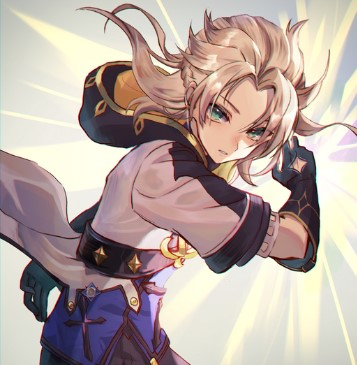

The matched document agains query Hu Tao fighting at position 1 is Ayaka


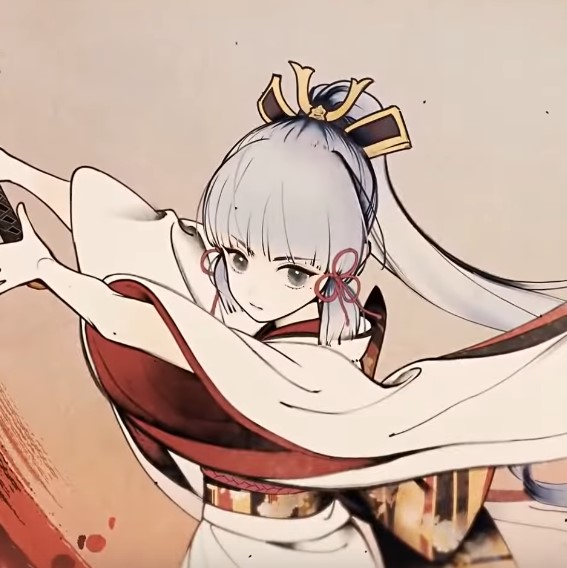

The matched document agains query Hu Tao fighting at position 2 is Neither


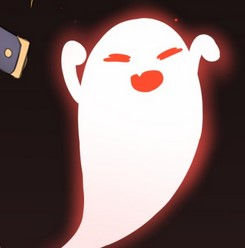

The matched document agains query Hu Tao fighting at position 3 is Ayaka


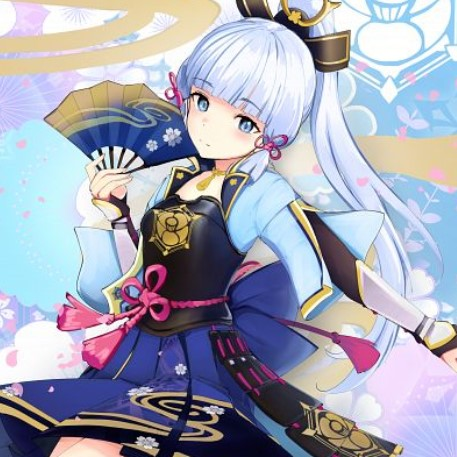

The matched document agains query Hu Tao fighting at position 4 is Hu Tao


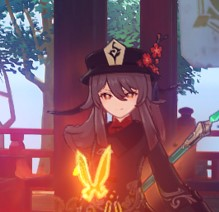

In [6]:
# embed a user query
query = 'Hu Tao fighting'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

The matched document agains query Ayaka dancing at position 0 is Ayaka


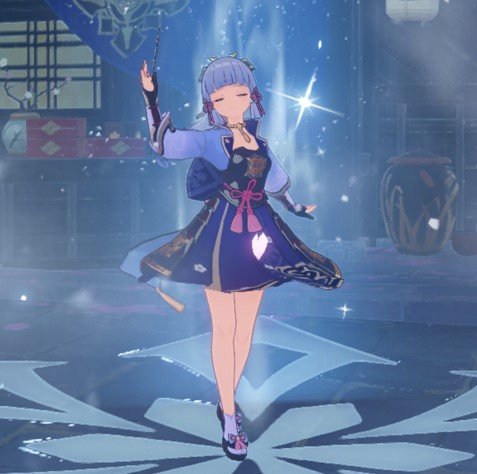

The matched document agains query Ayaka dancing at position 1 is Ayaka


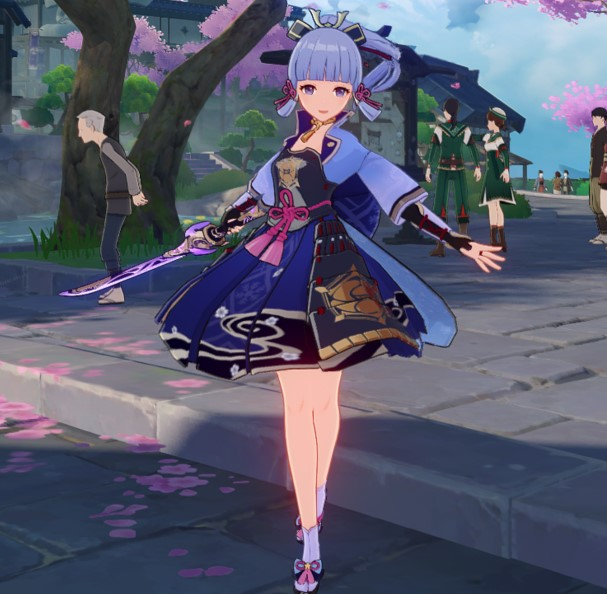

The matched document agains query Ayaka dancing at position 2 is Ayaka


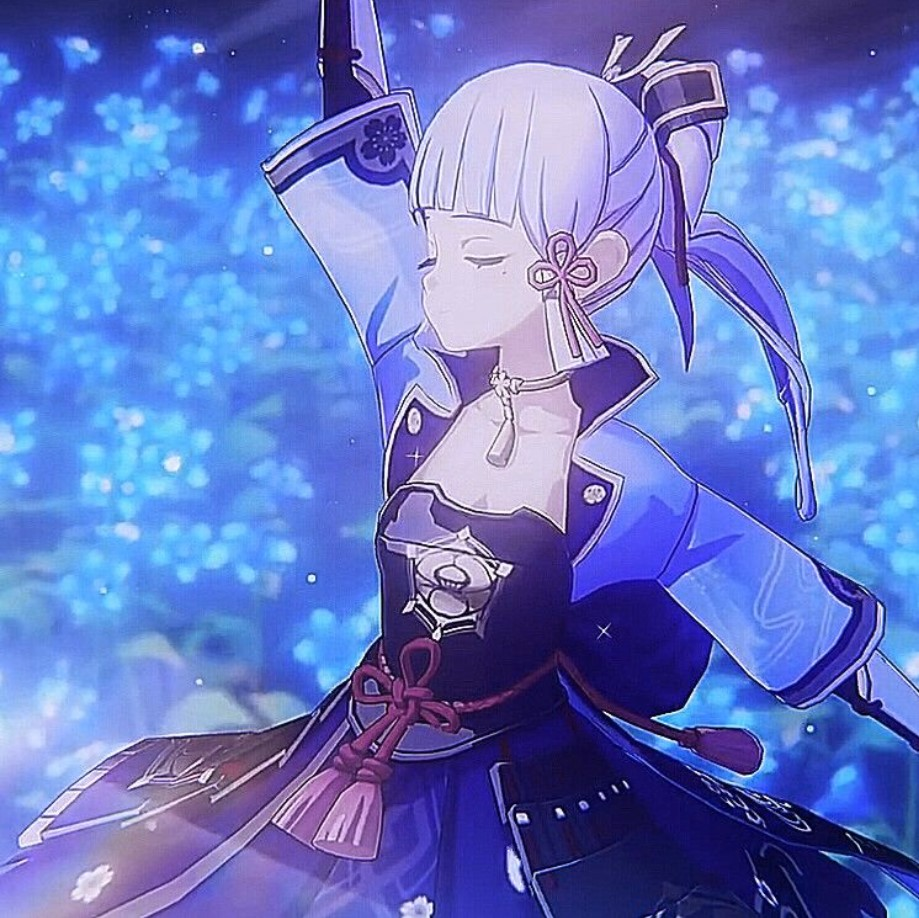

The matched document agains query Ayaka dancing at position 3 is Ayaka


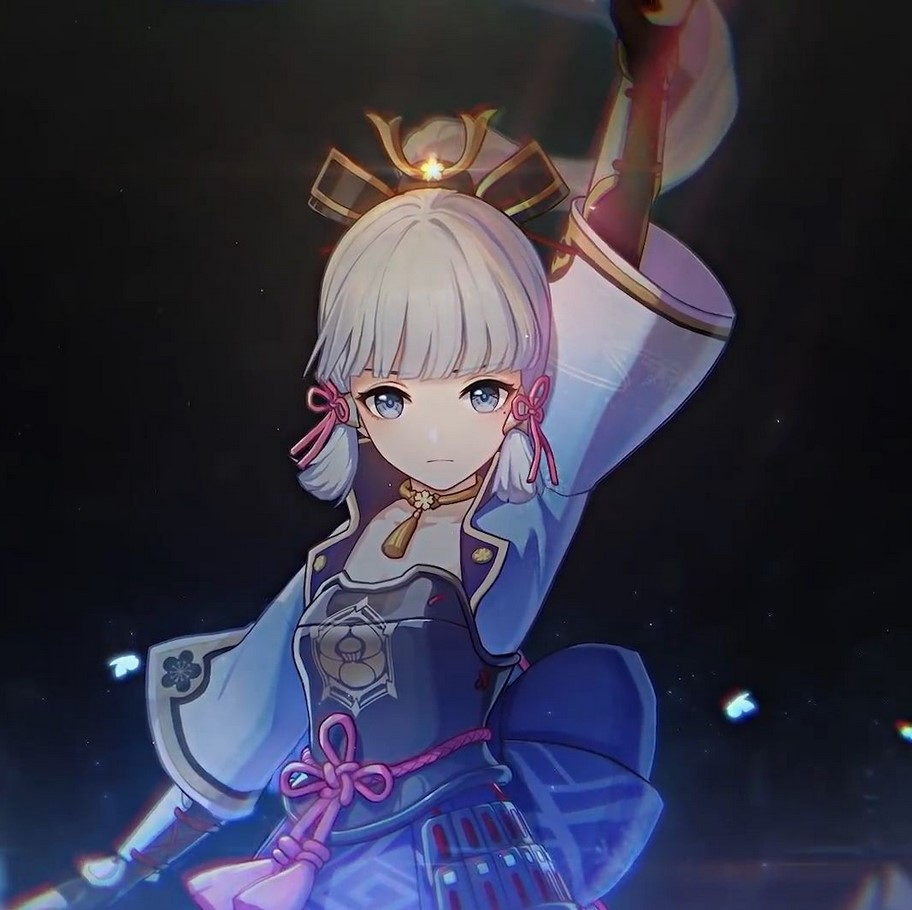

The matched document agains query Ayaka dancing at position 4 is Ayaka


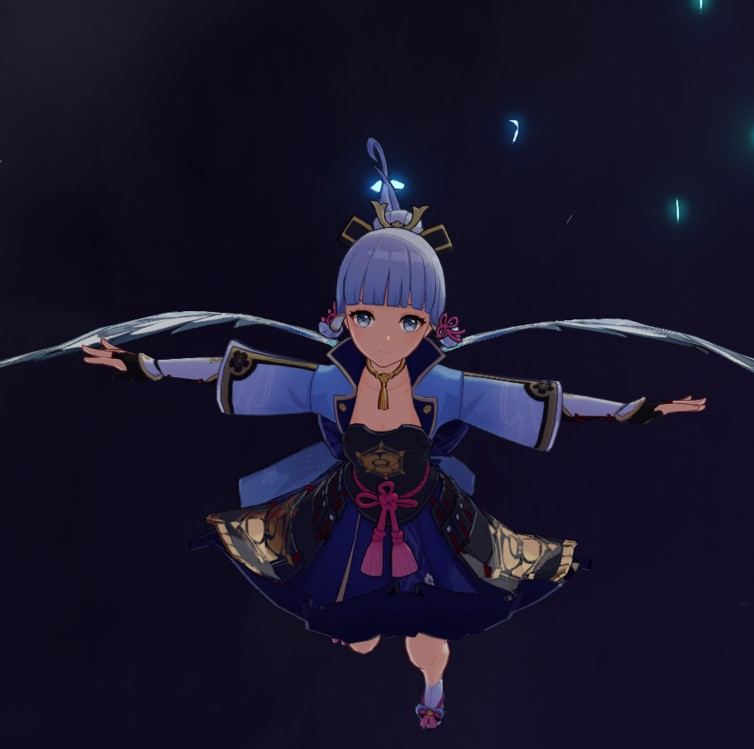

In [7]:
# embed a user query
query = 'Ayaka dancing'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()

In [9]:
!pip install typing-extensions==4.5.0

In [10]:
import finetuner

In [11]:
finetuner.login()

In [12]:
pairs = DocumentArray() # initialize a DocumentArray as final training data.

prompt = 'This is a photo of '
for doc in train_da:
    pair = Document()
    img_chunk = doc.load_uri_to_image_tensor(224, 224)
    img_chunk.modality = 'image'
    txt_chunk = Document(content=prompt + doc.tags['finetuner_label'])
    txt_chunk.modality = 'text'
    pair.chunks.extend([img_chunk, txt_chunk])
    # add pair to pairs
    pairs.append(pair)

# Lets see the first item of the pairs
pairs[0]

📄 Document: 7270c474c14c34bd7893b7d2c028163f
└── 💠 Chunks
    ├── 📄 Document: 41a05d7c91af9a5fee5ba686e961a282
    │   ╭────────────┬─────────────────────────────────────────────────────────────────╮
    │   │ Attribute  │ Value                                                           │
    │   ├────────────┼─────────────────────────────────────────────────────────────────┤
    │   │ tensor     │ <class 'numpy.ndarray'> in shape (224, 224, 3), dtype: uint8    │
    │   │ mime_type  │ image/jpeg                                                      │
    │   │ uri        │ /content/dataset/Kokomi/82.jpg                                  │
    │   │ tags       │ {'finetuner_label': 'Kokomi'}                                   │
    │   │ modality   │ image                                                           │
    │   ╰────────────┴─────────────────────────────────────────────────────────────────╯
    └── 📄 Document: 8a41dc70d2b977efeea3cd05e7f2db62
        ╭───────────────────────┬──────────────────────────────────────────────────────╮
        │ Attribute             │ Value                                                │
        ├───────────────────────┼──────────────────────────────────────────────────────┤
        │ text                  │ This is a photo of Kokomi                            │
        │ modality              │ text                                                 │
        ╰───────────────────────┴──────────────────────────────────────────────────────╯

In [13]:
run = finetuner.fit(
    model='openai/clip-vit-base-patch32', # fine-tune CLIP
    train_data=pairs,
    learning_rate=1e-5,
    loss='CLIPLoss',
)

Pushing a DocumentArray to Jina AI Cloud under the name finetuner-dastorage-default-vigilant-kapitsa-train ...


🔐 You are logged in to Jina AI as sleeping4cat (username: sleeping4cat). To log out, use jina auth logout.

Output()

In [14]:
for entry in run.stream_logs():
    print(entry)

Output()

[12:27:18] INFO     Starting finetuner training run ...                                                  __main__.py:350
DEBUG    Found Jina AI Cloud authentication token                                             __main__.py:362
DEBUG    Running in online mode                                                               __main__.py:363
INFO     Reading config ...                                                                   __main__.py:370
DEBUG    Reading config from stream                                                           __main__.py:382
INFO     Parsing config ...                                                                   __main__.py:385
INFO     Config loaded 📜                                                                     __main__.py:389
INFO     Run name: vigilant-kapitsa                                                           __main__.py:391
INFO     Experiment name: default                                                             __main__.py:392


In [15]:
# save the artifact
artifact = run.save_artifact('/content/')

Output()

In [16]:
clip_text_encoder = finetuner.get_model(artifact=artifact, select_model='clip-text')
clip_image_encoder = finetuner.get_model(artifact=artifact, select_model='clip-vision')

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [17]:
finetuner.encode(model=clip_image_encoder, data=test_da)

Output()

╭──────────────────────────── Documents Summary ─────────────────────────────╮
│                                                                            │
│   Type                   DocumentArrayInMemory                             │
│   Length                 250                                               │
│   Homogenous Documents   True                                              │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                             │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   250              False             │
│   id          ('str',)       250              False             │
│   mime_type   ('str',)       1                False             │
│   tags        ('dict',)      250              False             │
│   uri         ('str',)       250              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

Output()

The matched document again query Kokomi fighting at position 0 is Kokomi


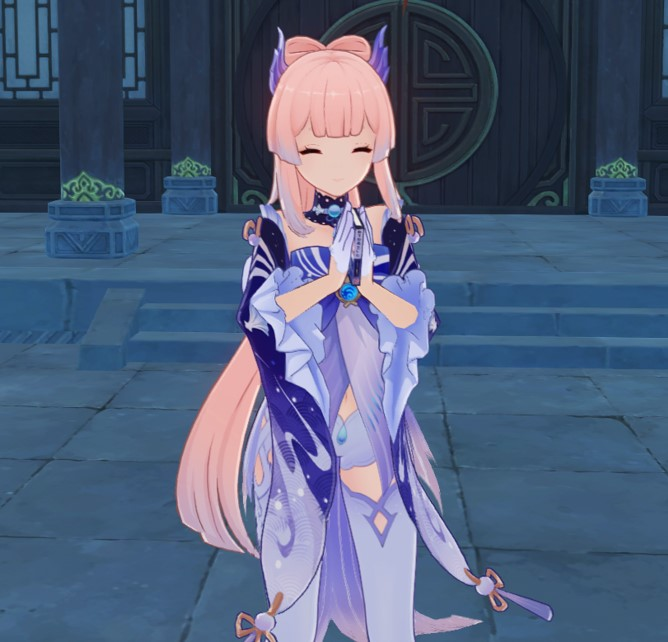

The matched document again query Kokomi fighting at position 1 is Kokomi


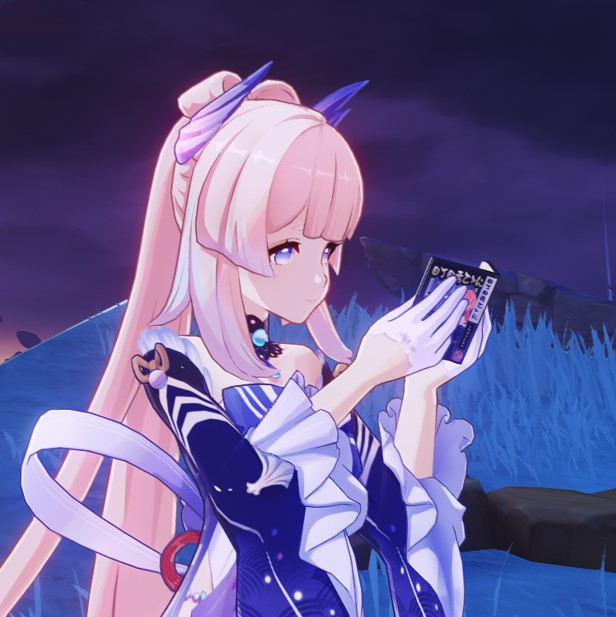

The matched document again query Kokomi fighting at position 2 is Kokomi


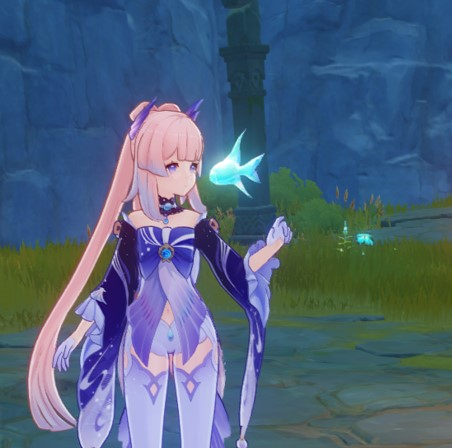

The matched document again query Kokomi fighting at position 3 is Kokomi


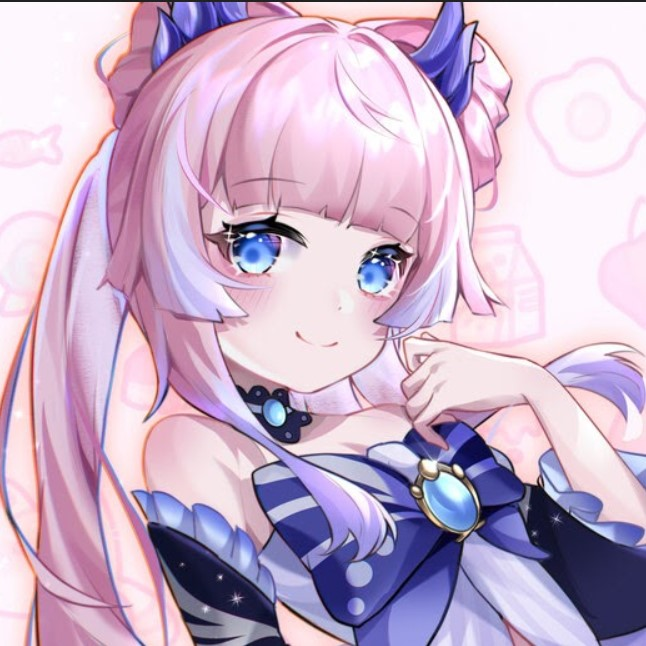

The matched document again query Kokomi fighting at position 4 is Kokomi


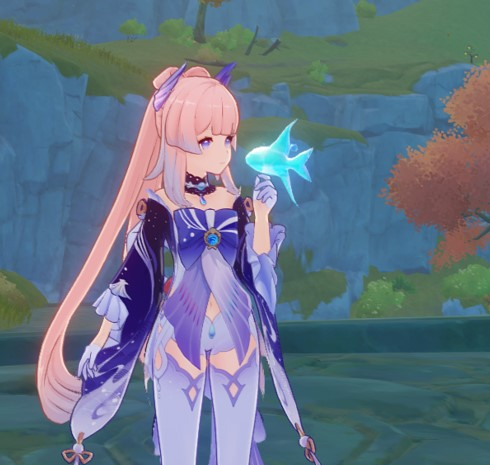

In [21]:
# embed a user query, in this case, the query keywords is "Hu Tao fighting"
query = 'Kokomi fighting'
query_docs = DocumentArray([Document(content=query)])

finetuner.encode(model=clip_text_encoder, data=query_docs)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document again query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()